In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report
from wordcloud import WordCloud
from collections import Counter

In [2]:
# Load the training and testing data
train_df = pd.read_csv('Dataset of Malicious and Benign Webpages/Webpages_Classification_train_data.csv/Webpages_Classification_train_data.csv')
test_df = pd.read_csv('Dataset of Malicious and Benign Webpages/Webpages_Classification_test_data.csv/Webpages_Classification_test_data.csv')

In [3]:
# Select only 'content' and 'label' columns
train_df = train_df[['content', 'label']]
test_df = test_df[['content', 'label']]

In [4]:
# Function to get stratified sample
def get_stratified_sample(df, n_samples):
    return df.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), n_samples // 2)))


In [5]:
# Get stratified samples
train_df_sample = get_stratified_sample(train_df, 20000)
test_df_sample = get_stratified_sample(test_df, 20000)

In [6]:
# EDA Functions
def plot_label_distribution(df, title):
    plt.figure(figsize=(10, 6))
    df['label'].value_counts().plot(kind='bar')
    plt.title(f'Label Distribution - {title}')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

def plot_content_length_distribution(df, title):
    df['content_length'] = df['content'].str.len()
    plt.figure(figsize=(10, 6))
    sns.histplot(df['content_length'], bins=50, kde=True)
    plt.title(f'Content Length Distribution - {title}')
    plt.xlabel('Content Length')
    plt.ylabel('Count')
    plt.show()

def generate_wordcloud(df, label):
    text = ' '.join(df[df['label'] == label]['content'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {label} Webpages')
    plt.show()

def plot_top_words(df, label, n=20):
    text = ' '.join(df[df['label'] == label]['content'])
    word_freq = Counter(text.split())
    top_words = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:n])
    plt.figure(figsize=(12, 6))
    plt.bar(top_words.keys(), top_words.values())
    plt.title(f'Top {n} Words in {label} Webpages')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()

In [7]:
# Perform EDA
print("Exploratory Data Analysis")
print("Training Data Sample:")
print(train_df_sample.info())
print("\nTest Data Sample:")
print(test_df_sample.info())

Exploratory Data Analysis
Training Data Sample:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 844294 to 1049157
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  20000 non-null  object
 1   label    20000 non-null  object
dtypes: object(2)
memory usage: 468.8+ KB
None

Test Data Sample:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18062 entries, 146528 to 99708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  18062 non-null  object
 1   label    18062 non-null  object
dtypes: object(2)
memory usage: 423.3+ KB
None


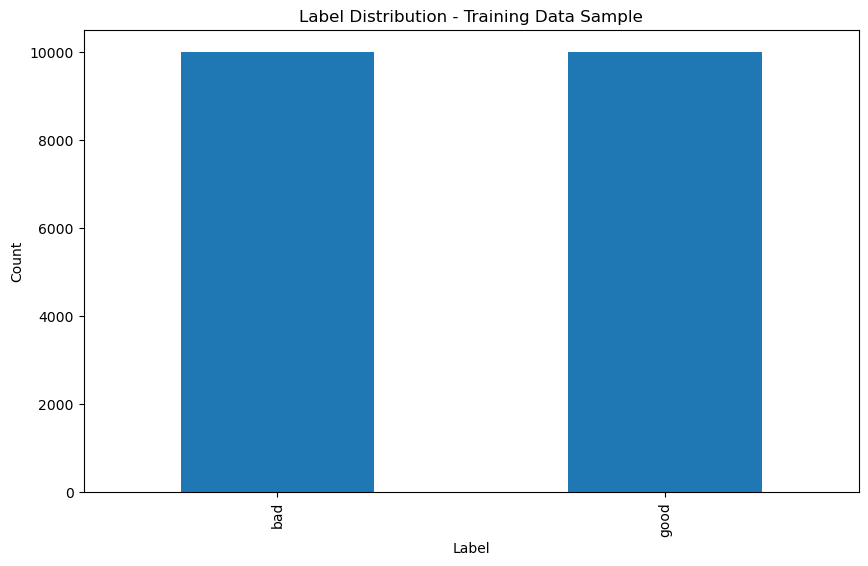

In [8]:
plot_label_distribution(train_df_sample, 'Training Data Sample')

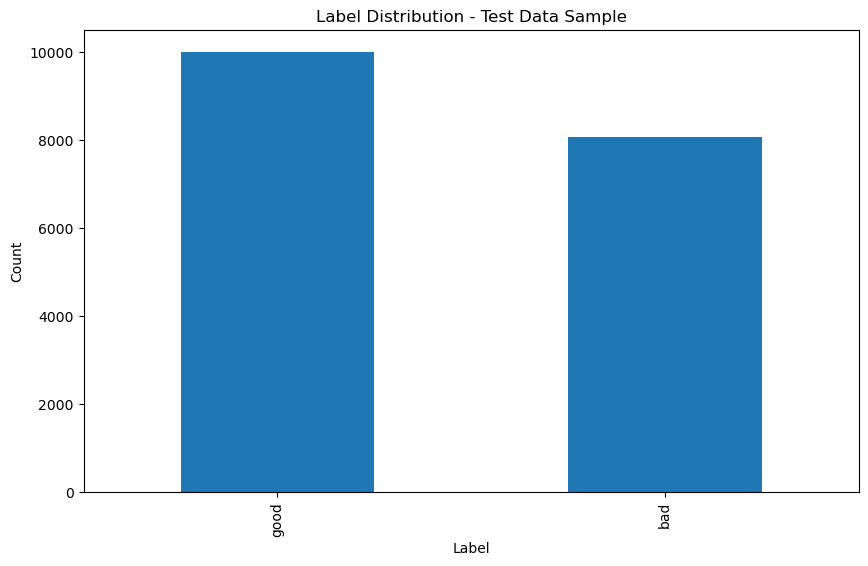

In [9]:

plot_label_distribution(test_df_sample, 'Test Data Sample')

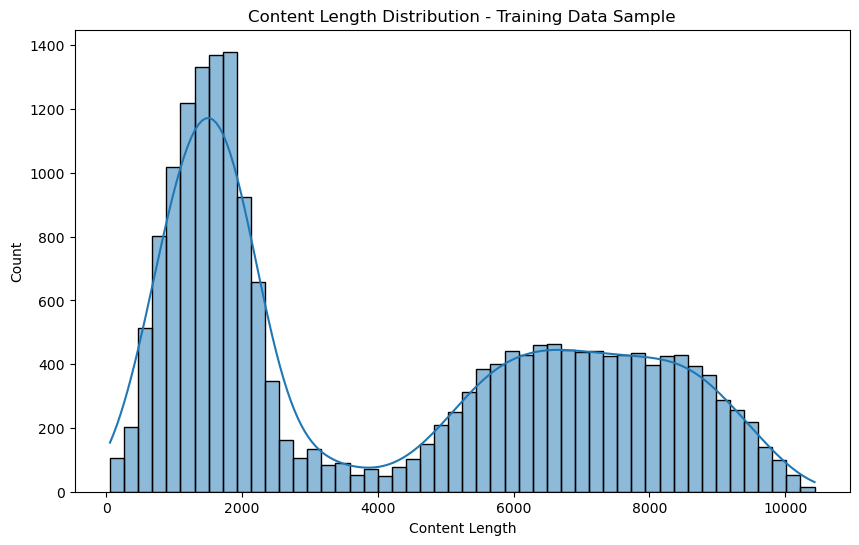

In [10]:
plot_content_length_distribution(train_df_sample, 'Training Data Sample')

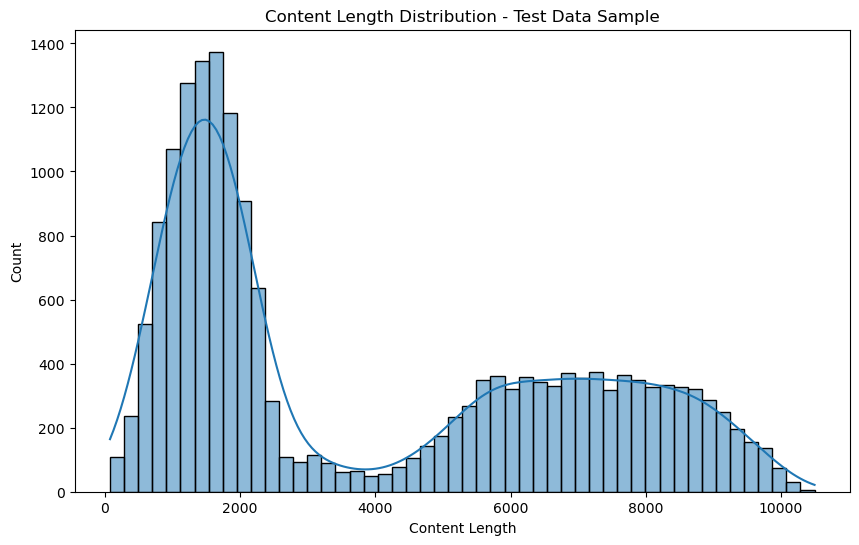

In [11]:
plot_content_length_distribution(test_df_sample, 'Test Data Sample')

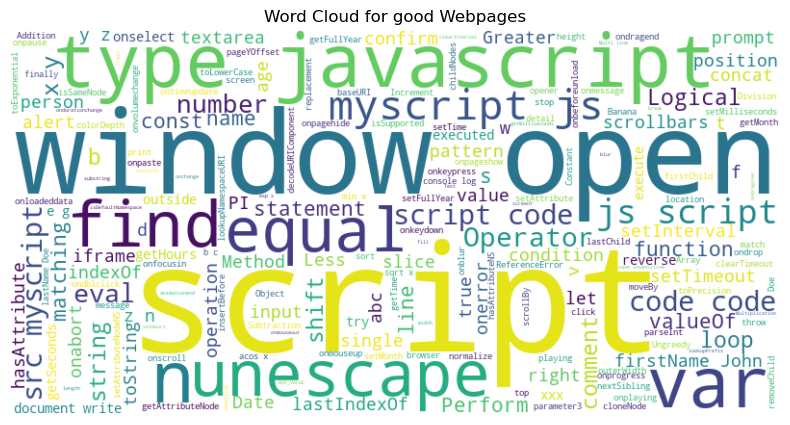

In [12]:
generate_wordcloud(train_df_sample, 'good')

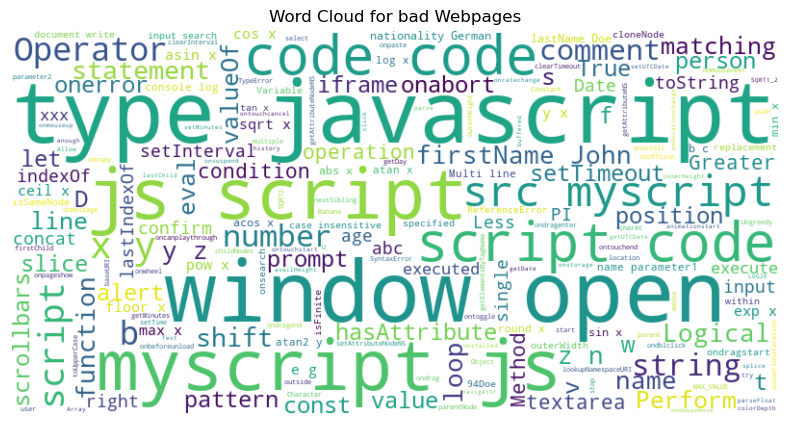

In [13]:
generate_wordcloud(train_df_sample, 'bad')

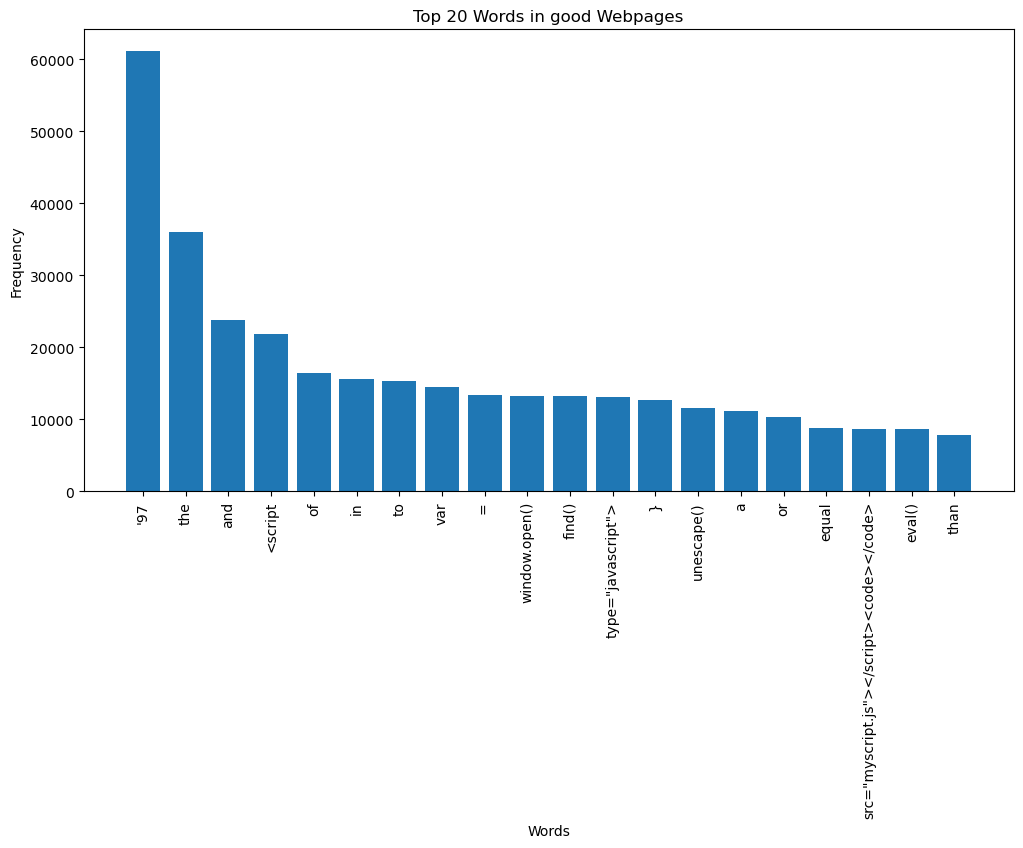

In [14]:
plot_top_words(train_df_sample, 'good')

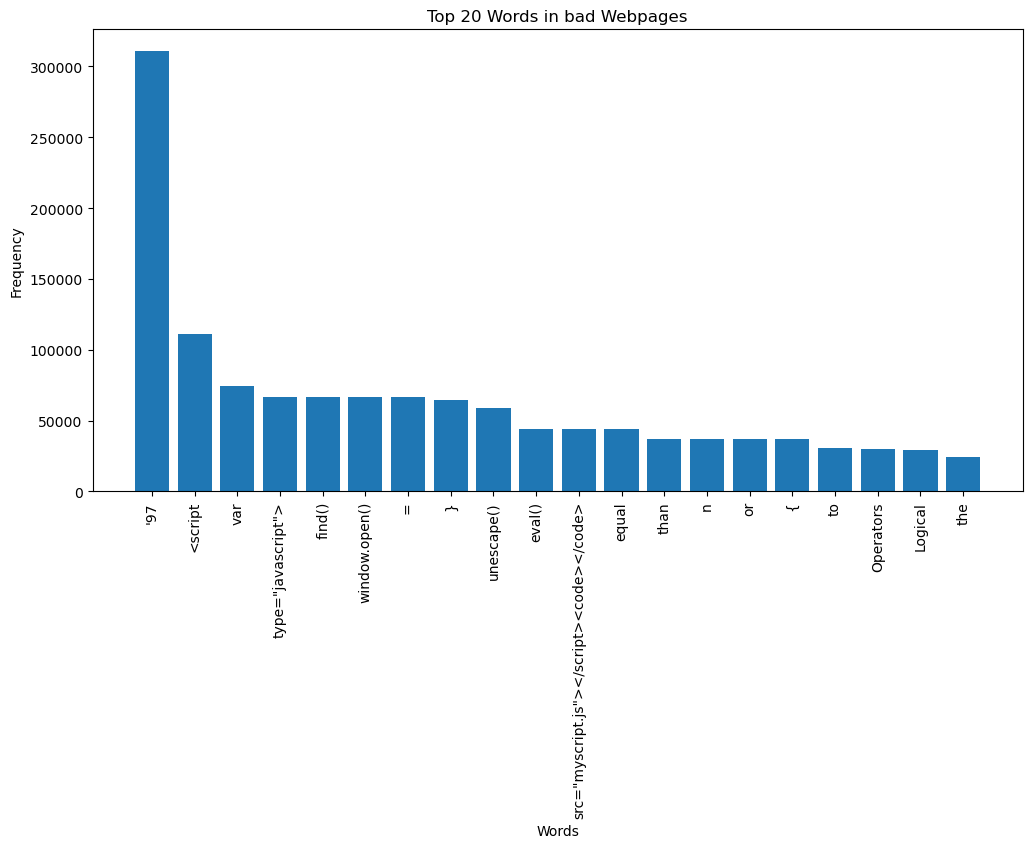

In [15]:
plot_top_words(train_df_sample, 'bad')

In [16]:
# Data Preprocessing
X_train = train_df_sample['content']
y_train = train_df_sample['label']

X_test = test_df_sample['content']
y_test = test_df_sample['label']

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = max(len(x) for x in X_train_seq)
X_train_seq = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_seq = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [17]:
# CNN + LSTM Hybrid Model
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=max_length),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(64, return_sequences=True),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
# Train the model
history = model.fit(X_train_seq, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/10
500/500 [==============================] - 222s 438ms/step - loss: 0.2202 - accuracy: 0.9334 - val_loss: 0.2628 - val_accuracy: 0.9565
Epoch 2/10
500/500 [==============================] - 210s 421ms/step - loss: 0.1445 - accuracy: 0.9507 - val_loss: 0.1632 - val_accuracy: 0.9525
Epoch 3/10
500/500 [==============================] - 210s 420ms/step - loss: 0.0606 - accuracy: 0.9766 - val_loss: 0.1606 - val_accuracy: 0.9315
Epoch 4/10
500/500 [==============================] - 219s 438ms/step - loss: 0.0246 - accuracy: 0.9918 - val_loss: 0.2811 - val_accuracy: 0.9388
Epoch 5/10
500/500 [==============================] - 384s 768ms/step - loss: 0.0147 - accuracy: 0.9948 - val_loss: 0.3142 - val_accuracy: 0.9317
Epoch 6/10
500/500 [==============================] - 259s 519ms/step - loss: 0.0094 - accuracy: 0.9966 - val_loss: 0.3427 - val_accuracy: 0.9373
Epoch 7/10
500/500 [==============================] - 237s 473ms/step - loss: 0.0048 - accuracy: 0.9983 - val_loss: 0.4114 -

In [19]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_seq, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

565/565 [==============================] - 68s 118ms/step - loss: 0.3387 - accuracy: 0.9472
Test Accuracy: 0.95


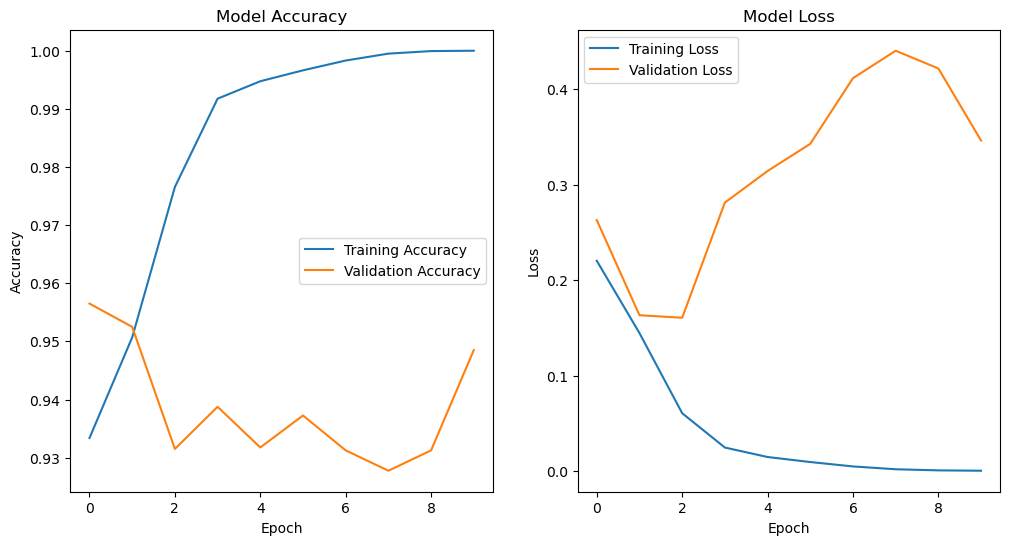

In [20]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [21]:
# Make predictions
y_pred = model.predict(X_test_seq)
y_pred_classes = (y_pred > 0.5).astype(int)


565/565 [==============================] - 66s 116ms/step


In [22]:
# Print classification report
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      8062
           1       0.96      0.94      0.95     10000

    accuracy                           0.95     18062
   macro avg       0.95      0.95      0.95     18062
weighted avg       0.95      0.95      0.95     18062



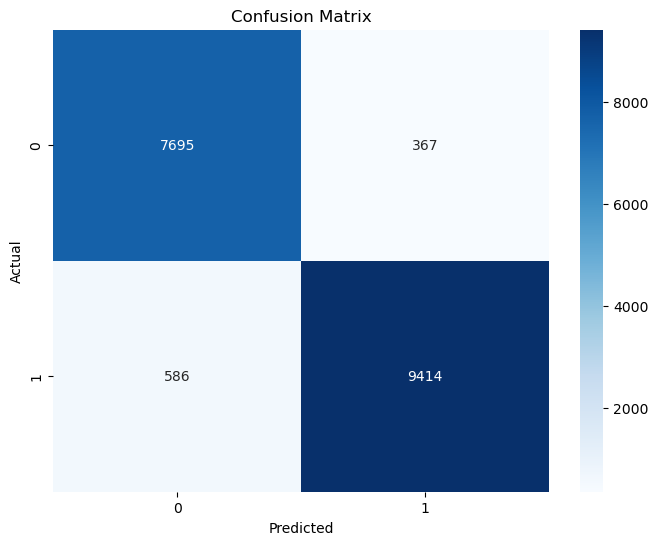

In [23]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()